<h1>Predicting the Popularity of a Mobile App on the Google Play Store</h1>
<h2>Kenneth Jiang (kjiang12)</h2>

![title](page.0.webp)

<h3>Introduction</h3>


The Google Play Store is the default app store for most Android devices and is the largest mobile app distributor currently in existence, hosting over 2 million apps worldwide. In this project, we are going to take a look at a small sub-section of these apps and attempt to develop a prediction model for determining how many people will install a given app.

<h4>Requirements</h4>

- Pandas
- NumPy
- Seaborn
- Sklearn

<h3>Data Collection</h3>

The dataset we will be working with comes from Kaggle (https://www.kaggle.com/gauthamp10/google-playstore-apps/) and contains recently updated (8 months ago as of December 2019) statistics for over 267,000 applications on the Google Play Store. The data itself was obtained by running a python scrapper on the Google Play website.

In [60]:
import pandas as pd

# Fetching data
data = pd.read_csv("Google-Playstore-Full.csv")
data.head()

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,DoorDash - Food Delivery,FOOD_AND_DRINK,4.548561573,305034,"5,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
1,TripAdvisor Hotels Flights Restaurants Attract...,TRAVEL_AND_LOCAL,4.400671482,1.20792e+06,"100,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
2,Peapod,SHOPPING,3.656329393,1967,"100,000+",1.4M,0,Everyone,"September 20, 2018",5.0 and up,2.2.0,NaN,NaN,NaN,NaN
3,foodpanda - Local Food Delivery,FOOD_AND_DRINK,4.107232571,389154,"10,000,000+",16M,0,Everyone,"March 22, 2019",4.2 and up,4.18.2,NaN,NaN,NaN,NaN
4,My CookBook Pro (Ad Free),FOOD_AND_DRINK,4.647752285,2291,"10,000+",Varies with device,$5.99,Everyone,"April 1, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN


<h4>Data Cleanup</h4>
The first thing we need to do is to tidy our data. First, we are going to remove all of the unnecessary columns. This includes the unnamed columns as well as the unique identifiers (version and name). In addition, we are going to remove all rows with incomplete data, which include NaNs and device sensitive values.

In [61]:
# Removing empty columns
data.drop(data.columns[[11,12,13,14]], axis=1, inplace=True)

# Removing unique identifying information
data.drop(columns=["App Name", "Latest Version", "Last Updated"], inplace=True)

# Removing rows with incomplete data
data = data[data.Size != "Varies with device"]
data = data[data["Minimum Version"] != "Varies with device"]
data = data.dropna()

Now, we are going to convert the Price column in float values that we can use later. In addition, we're also going to create a new column to differentiate free apps from paid apps

In [62]:
# Parsing price column
data["Price"] = data["Price"].str.replace("$", "")

# Filter out invalid prices
data = data[data['Price'].apply(lambda x: x.replace('.','',1).isdigit())]

data["Price"] = data["Price"].astype(float)

# Creating boolean column
data["Free"] = (data["Price"] == 0)

We are going to do the same thing to the size column and convert all of the various sizes into bytes. 

In [63]:
import numpy as np

def expand_size(val):
    val = val.replace(",", "")
    if val[-1] == "G":
        return float(val[:-1]) * 1000000000
    elif val[-1] == "M":
        return float(val[:-1]) * 1000000
    elif val[-1] == "k":
        return float(val[:-1]) * 1000
    else:
        return np.nan
    
# Parsing size column
data["Size"] = data["Size"].apply(lambda x: expand_size(x))
data = data.dropna()

For the minimum android version, we are going to remove the excess text to focus the column on the version number.

In [64]:
import re
def version_parser(val):
    p = re.compile("([0-9.]+)")
    result = p.search(val)
    return result.group(1)

# Parsing min version column
data["Minimum Version"] = data["Minimum Version"].apply(lambda x : version_parser(x))
data = data.dropna()

To determine the popularity of an app, we are going to use the install levels denoted in the install column as our metric. Since these two conditions are directly correlated, as more popular apps will have larger install numbers, this is going to be our target variable.

To process this column, we are going to sort the levels (by converting the values into floats) and then label code, with 0 being the least popular and 19 being the most popular.

In [65]:
# Parsing install counts
data["Installs"] = data["Installs"].apply(lambda x : float(x.replace(",", "")[:-1]))
data = data.dropna()

# Label encoding
data["Installs"] =  data['Installs'].astype('category')
data["Installs"] = data["Installs"].cat.codes

# Data casting
data["Rating"] = data["Rating"].astype(float)

In the end, our data table should look something like this:

In [66]:
data.head()

,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Minimum Version,Free
2,SHOPPING,3.656329,1967,11,1400000.0,0.0,Everyone,5.0,True
3,FOOD_AND_DRINK,4.107233,389154,15,16000000.0,0.0,Everyone,4.2,True
5,FOOD_AND_DRINK,3.825322,2559,11,23000000.0,0.0,Everyone,5.0,True
8,TRAVEL_AND_LOCAL,3.811765,85,9,4100000.0,0.0,Everyone,4.3,True
12,LIFESTYLE,3.213528,754,11,39000000.0,0.0,Everyone,5.0,True


<h3>Exploratory Analysis</h3>

Now, lets take a peek at our data.

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

<h4>Target Exploration</h4>

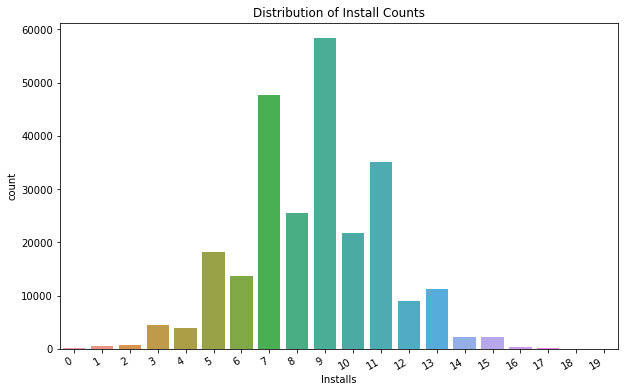

In [68]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Installs", data=data)
ax.set_title("Distribution of Install Counts")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

The first thing we are going to look at is the distribution of install counts, our target variable. We can see that it is roughly normal, with the majority of applications having middling levels of popularity.

<h4>Feature Exploration</h4>

We are know going to look at how the distribution of install counts differ when we take the other columns into account. Columns that show signifcant change between variables may help predict installation numbers.

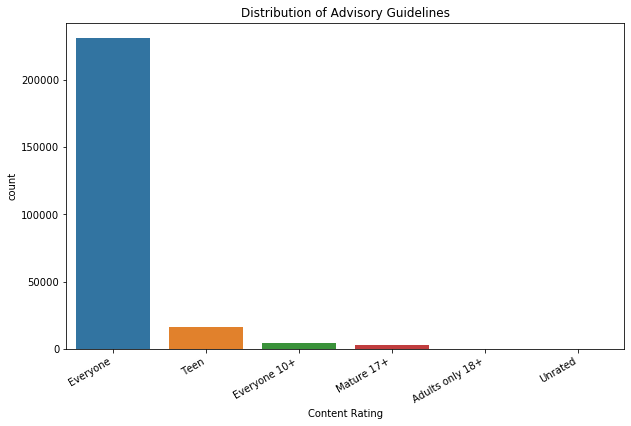

In [69]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Content Rating", data=data)
ax.set_title("Distribution of Advisory Guidelines")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

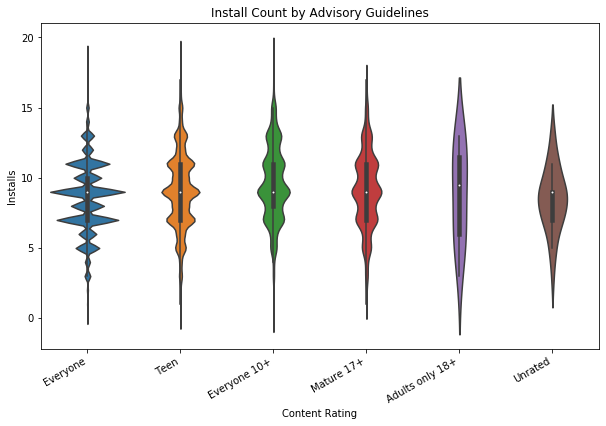

In [73]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="Content Rating", y="Installs", data=data, height=7)
ax.set_title('Install Count by Advisory Guidelines')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

The first feature we are going to look at is the advisory guideline, which is the recommended audience for each app. From the first graph, we can see that the majority of apps are rated "Everyone", which makes sense since that is the broadest category. From the second app, we can see that the distribution of install numbers differs significantly between categories. The three broadest categories (Everyone, Teen, and Everyone 10+) have a much more diverse range of values, while the others are stuck at the low end of the scale. 

Text(0.5, 1.0, 'Install Count by User Ratings')

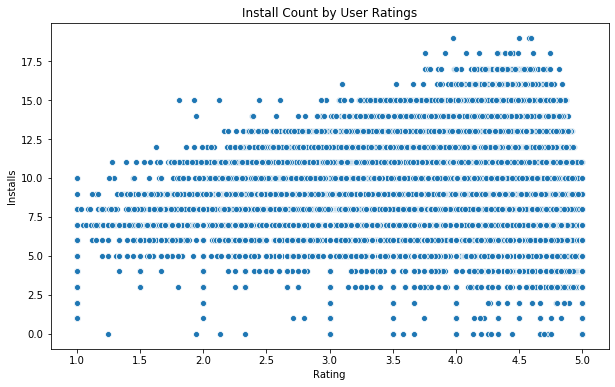

In [74]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Rating", y="Installs", data=data)
ax.set_title('Install Count by User Ratings')

Now we are going to look at user ratings. From this scatter plot, it seems like there is some sort of correlation. The apps with higher install numbers tend to also have higher ratings. None of the apps with low ratings (>2.5) seem to have particularly high install numbers either.

Text(0.5, 1.0, 'Free vs Paid Apps')

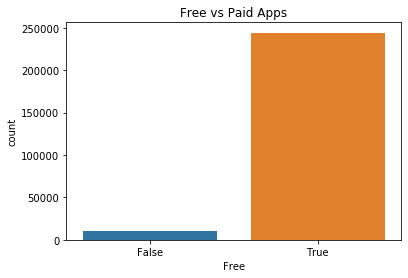

In [13]:
sns.countplot(x="Free", data=data).set_title("Free vs Paid Apps")

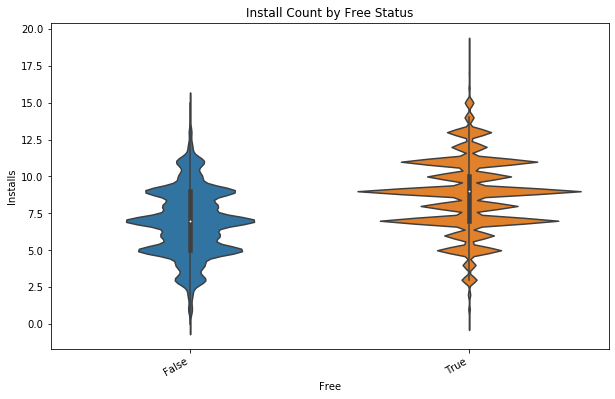

In [76]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="Free", y="Installs", data=data)
ax.set_title('Install Count by Free Status')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

The next category we are going to look at is the price. Given the that the vast majority of apps are free, as seen in the first graph, I have decided to combine all of the paid apps together and analyze this feature as a boolean. From the second graph, we can see that paid apps tend to have much smaller install bases, and that the distributions of the two are wildly different. All of the most popular apps are free. 

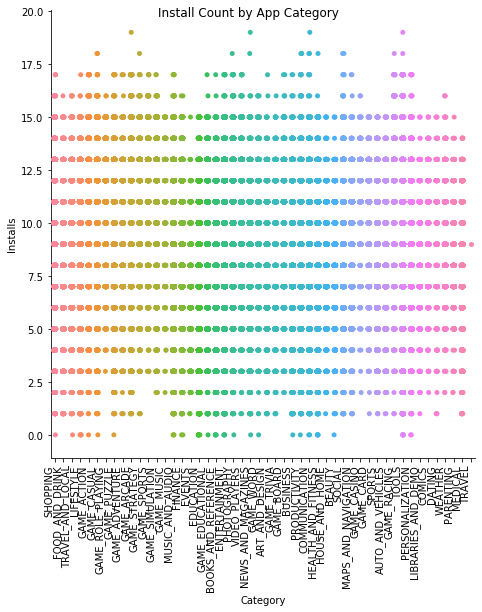

In [77]:
g = sns.catplot(x="Category", y="Installs", jitter=1, data=data, height=7)
g.fig.suptitle('Install Count by App Category')
[plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right') for ax in g.axes.flat]
plt.show()

Next we are going to look at the app category. Since there are so many of them, it may be slightly hard to decipher this graph, but in general, it seems like the install distributions do differ between them, with simulation games, word games, house and home, and libraries and demo being the most lucretive categories.

Text(0.5, 1.0, 'Install Count by App Size')

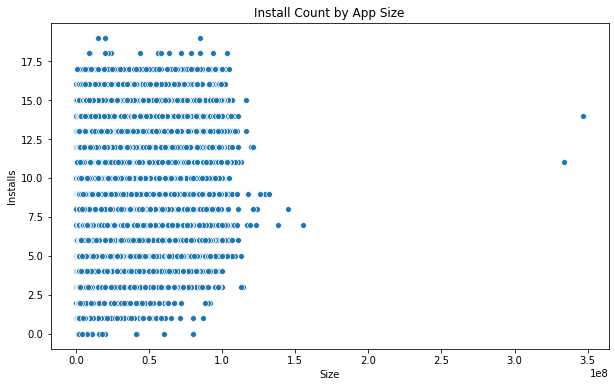

In [78]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Size", y="Installs", data=data)
ax.set_title('Install Count by App Size')

App size on the other hand doesn't seem to impact popularity. There is no obvious correlation between the two features as apps of any size seem to be able to get high install numbers.

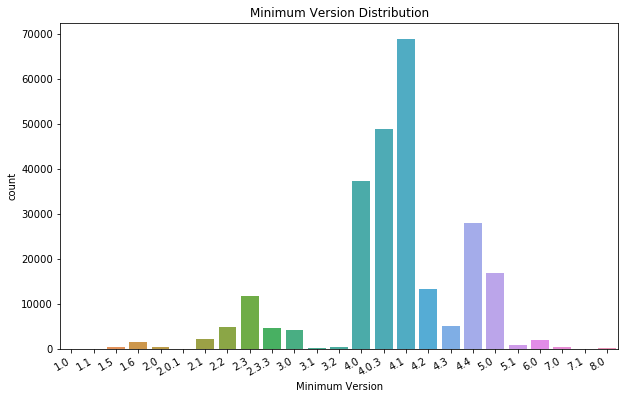

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="Minimum Version", data=data.sort_values(by="Minimum Version"))
ax.set_title("Minimum Version Distribution")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

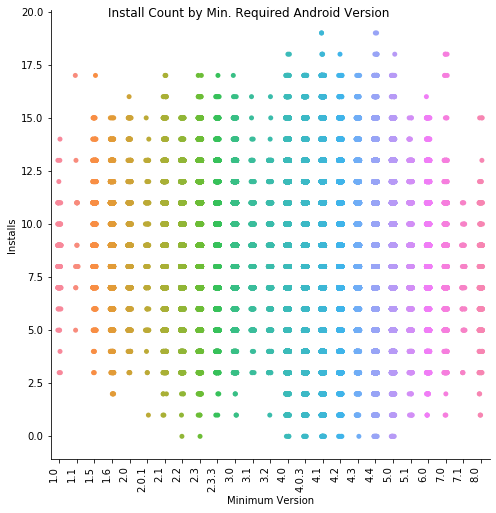

In [79]:
g = sns.catplot(x="Minimum Version", y="Installs", jitter=1, data=data.sort_values(by="Minimum Version"), height=7)
g.fig.suptitle('Install Count by Min. Required Android Version')
[plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right') for ax in g.axes.flat]
plt.show()

And finally the last feature. The minimum version is the lowest Android OS version that is eligible to install a given app. The lower the version, the larger the potential install base. However, lower versions have less features than newer versions, so most apps tend to go chose a version in the middle, as seen in the first graph. It seems like the installation distributions for each version do differ, with most of the lucreative apps being between versions 4 and 5.

<h3>Building the Classifier</h3>

For this project, we are going to use a classifier instead of a regressor since the original data categorized apps into specific install/popularity levels. The specific classifier we are going to look at is random forest, which is an ensemble classifer that generates multiple decision tress to predict values. The specific features that we will be using are the rating, review count, paid app status, category, content rating, and minimum version.

<h4>Preprocessing</h4>
The first thing we need to do is to prep our data. We will copy over our features into a fresh dataframe and label encode the categorical variables.

In [82]:
import warnings


# Supress warnings
warnings.filterwarnings("ignore")

# Copy our features into a new dataframe
model_data = data[['Rating', 'Reviews', "Free"]].copy()
model_data["Free"] = model_data["Free"].astype(int)

# Label encode categorical variables
model_data["Category"] = data['Category'].astype('category')
model_data["Category"] = model_data["Category"].cat.codes
model_data["Content Rating"] = data['Content Rating'].astype('category')
model_data["Content Rating"] = model_data["Content Rating"].cat.codes
model_data["Minimum Version"] = data['Minimum Version'].astype('category')
model_data["Minimum Version"] = model_data["Minimum Version"].cat.codes

model_data.head()

,Rating,Reviews,Free,Category,Content Rating,Minimum Version
2,3.656329,1967,1,42,1,19
3,4.107233,389154,1,12,1,16
5,3.825322,2559,1,12,1,19
8,3.811765,85,1,47,1,17
12,3.213528,754,1,33,1,19


Now we need to transform the dataframe into NumPy arrays which the classifier can parse. In order to speed up computation times, we are going to limit the analysis to the first 10,000 entries.

In [83]:
model_target = data["Installs"].copy().head(10000)
model_target.to_numpy()

model_data = model_data.head(10000)
model_data = model_data.to_numpy()

<h4>Random Forest</h4>

Now lets create the model. Due to the large number of categories and features, we are going to use a classifier with 200 trees and a max depth of 50. 

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


model = RandomForestClassifier(n_estimators=200, max_depth=50)
forest_scores = cross_val_score(model, model_data, model_target, cv=10)

print("random forest CV score: %0.2f, error: %0.2f" % (forest_scores.mean(), forest_scores.std()))

random forest CV score: 0.53, error: 0.02


Through a 10-fold cross validation test, we can see that the model has an accuracy of 0.53. Considering the number of possible popularity categories (19), this result is fairly good when compared to randomly selecting a category, which has a $1/19 = 0.05$ chance of success.

<h3>Conclusion</h3>

This project was a pretty fun chance to put everything we learned this semester to the test in a full scale data science project. I feel like I learned a lot from it and would recommend that everyone should take this class. There are obvious rooms for improvement in this project, especially when it comes to the accuracy of the model. If I had more time, I would play around with the hyperparameters some more and explore other classification algorithms. 